In [5]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import glob
import matplotlib.image as mpimg

In [8]:
# ---------------------------
# 1. Hyperparameters
# ---------------------------
EPOCHS = 550               # Total epochs to train
BATCH_SIZE = 128
IMAGE_SIZE = 32
CHANNELS_IMG = 3
LATENT_DIM = 100
EMBED_DIM = 50             # Dimension for label embedding
CRITIC_ITER = 5            # Critic iterations per generator iteration
LAMBDA_GP = 10             # Gradient penalty lambda
LEARNING_RATE = 2e-4
BETA1, BETA2 = 0.5, 0.999
CHECKPOINT_EVERY = 20      # Save, sample images, compute IS/FID every 50 epochs
# CIFAR-10 class index for "automobile" is typically 1
AUTOMOBILE_CLASS_IDX = 1

In [9]:
# ---------------------------
# 2. Data Loading (CIFAR-10)
# ---------------------------
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
# Filter to get only automobile images
automobile_indices = [i for i, (_, label) in enumerate(trainset) if label == AUTOMOBILE_CLASS_IDX]
automobile_dataset = Subset(trainset, automobile_indices)

# Create dataloader with only automobile images
trainloader = DataLoader(
    automobile_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2
)


In [11]:
device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [13]:
# ---------------------------
# 3. Models: Generator & Discriminator (Critic)
# ---------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, embed_dim, num_classes=10):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Label embedding
        self.label_emb = nn.Embedding(num_classes, embed_dim)
        
        # Project + reshape to 4x4
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + embed_dim, 4*4*512),
            nn.BatchNorm1d(4*4*512),
            nn.ReLU(True)
        )
        
        # Upsampling (transposed conv) to produce 32x32 images
        self.deconv = nn.Sequential(
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, CHANNELS_IMG, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        # z: (batch_size, latent_dim)
        # labels: (batch_size)
        label_emb = self.label_emb(labels)            # (batch_size, embed_dim)
        concat = torch.cat([z, label_emb], dim=1)       # (batch_size, latent_dim+embed_dim)
        x = self.fc(concat)                           # (batch_size, 4*4*512)
        x = x.view(-1, 512, 4, 4)                      # (batch_size, 512, 4, 4)
        out = self.deconv(x)                          # (batch_size, 3, 32, 32)
        return out

In [14]:
class Discriminator(nn.Module):
    def __init__(self, embed_dim, num_classes=10):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        
        # Label embedding
        self.label_emb = nn.Embedding(num_classes, embed_dim)
        
        self.conv = nn.Sequential(
            nn.Conv2d(CHANNELS_IMG, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # For 32x32 images, final conv output is (512,2,2) => 512*2*2=2048
        self.fc = nn.Sequential(
            nn.Linear(512*2*2 + embed_dim, 1)
        )
        
    def forward(self, x, labels):
        batch_size = x.shape[0]
        features = self.conv(x)                     # (batch_size, 512, 2, 2)
        features = features.view(batch_size, -1)    # (batch_size, 2048)
        label_emb = self.label_emb(labels)          # (batch_size, embed_dim)
        concat = torch.cat([features, label_emb], dim=1)  # (batch_size, 2048 + embed_dim)
        validity = self.fc(concat)                  # (batch_size, 1)
        return validity


In [15]:
# ---------------------------
# 4. Gradient Penalty Function
# ---------------------------
def compute_gradient_penalty(critic, real_imgs, fake_imgs, labels, device="cpu"):
    alpha = torch.rand(real_imgs.size(0), 1, 1, 1, device=device)
    alpha = alpha.expand_as(real_imgs)
    interpolates = alpha * real_imgs + (1 - alpha) * fake_imgs
    interpolates = interpolates.requires_grad_(True)
    
    critic_interpolates = critic(interpolates, labels)
    grads = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    grads = grads.view(grads.size(0), -1)
    grad_norm = grads.norm(2, dim=1)
    gradient_penalty = ((grad_norm - 1) ** 2).mean()
    return gradient_penalty

In [16]:
# ---------------------------
# 5. Initialize Models & Optimizers
# ---------------------------
gen = Generator(latent_dim=LATENT_DIM, embed_dim=EMBED_DIM).to(device)
crit = Discriminator(embed_dim=EMBED_DIM).to(device)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
opt_crit = optim.Adam(crit.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

start_epoch = 1
checkpoint_path = "adl_part_1.pt"

In [17]:
# ---------------------------
# 6. Check for Existing Checkpoint
# ---------------------------
if os.path.exists(checkpoint_path):
    print("Checkpoint found. Loading...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    gen.load_state_dict(checkpoint["gen_state_dict"])
    crit.load_state_dict(checkpoint["crit_state_dict"])
    opt_gen.load_state_dict(checkpoint["opt_gen_state_dict"])
    opt_crit.load_state_dict(checkpoint["opt_crit_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming from epoch {start_epoch}.")


Checkpoint found. Loading...
Resuming from epoch 2.


In [18]:
# ---------------------------
# 7. Utility: Generate & Display Images for "Automobile"
# ---------------------------
def generate_and_show_samples(epoch, num_samples=10):
    gen.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, LATENT_DIM).to(device)
        labels = torch.full((num_samples,), AUTOMOBILE_CLASS_IDX, dtype=torch.long, device=device)
        fake_images = gen(z, labels).cpu()
    fake_images = (fake_images + 1) / 2.0  # Scale from [-1,1] to [0,1]
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*2.2, 2.2))
    for i in range(num_samples):
        img = fake_images[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.suptitle(f"Epoch {epoch}: Automobile Class Samples", fontsize=14)
    plt.savefig(f'task1/automobile_gan_losses_{epoch}.png')
    plt.show()
    gen.train()

In [19]:
# ---------------------------
# 8. Compute IS & FID with TorchMetrics
# ---------------------------
def compute_is_fid(generator, loader, n_samples=2000):
    is_metric = InceptionScore().to("cpu")
    fid_metric = FrechetInceptionDistance().to("cpu")
    generator.eval()

    real_count = 0
    for real_imgs, _ in loader:
        real_imgs = real_imgs.to(device)
        real_imgs_uint8 = (((real_imgs * 0.5) + 0.5) * 255).to(torch.uint8).cpu()
        fid_metric.update(real_imgs_uint8, real=True)
        real_count += real_imgs.size(0)
        if real_count >= n_samples:
            break

    fake_count = 0
    while fake_count < n_samples:
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        labels = torch.randint(0, 10, (BATCH_SIZE,), dtype=torch.long, device=device)
        with torch.no_grad():
            fake_out = generator(z, labels)
        fake_out_uint8 = (((fake_out * 0.5) + 0.5) * 255).to(torch.uint8).cpu()
        is_metric.update(fake_out_uint8)
        fid_metric.update(fake_out_uint8, real=False)
        fake_count += BATCH_SIZE

    inception_score = is_metric.compute()  # (mean, std)
    fid_score = fid_metric.compute()
    generator.train()
    return inception_score[0].item(), fid_score.item()

print(f"Starting training from epoch {start_epoch} to {EPOCHS}...")

Starting training from epoch 2 to 550...


==> Epoch 400: Inception Score = 3.7266, FID = 114.5365
[Epoch 401/550]  Loss Crit: -24808.4199  Loss Gen: 13574.6162
[Epoch 402/550]  Loss Crit: -28544.2969  Loss Gen: 13639.5449
[Epoch 403/550]  Loss Crit: -28645.6289  Loss Gen: 13723.1406
[Epoch 404/550]  Loss Crit: -25218.1562  Loss Gen: 13741.7598
[Epoch 405/550]  Loss Crit: -28948.5801  Loss Gen: 13839.0479
[Epoch 406/550]  Loss Crit: -29050.4785  Loss Gen: 13941.4092
[Epoch 407/550]  Loss Crit: -29194.2051  Loss Gen: 10296.4570
[Epoch 408/550]  Loss Crit: -18304.2715  Loss Gen: 14030.1875
[Epoch 409/550]  Loss Crit: -25827.9648  Loss Gen: 14085.8076
[Epoch 410/550]  Loss Crit: -29603.1445  Loss Gen: 14140.7402
[Epoch 411/550]  Loss Crit: -29727.2871  Loss Gen: 14233.7188
[Epoch 412/550]  Loss Crit: -22439.9258  Loss Gen: 14299.4873
[Epoch 413/550]  Loss Crit: -26277.9141  Loss Gen: 14354.5234
[Epoch 414/550]  Loss Crit: -22621.7656  Loss Gen: 14435.1035
[Epoch 415/550]  Loss Crit: -30260.2422  Loss Gen: 14505.7754
[Epoch 416/550

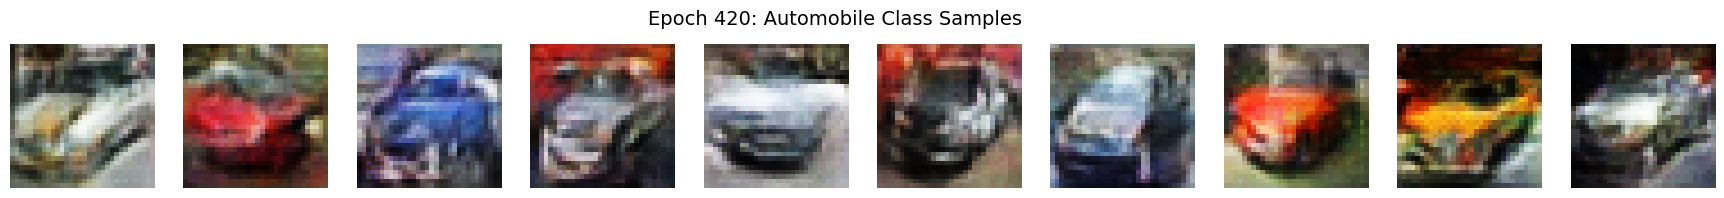

==> Epoch 420: Inception Score = 3.6283, FID = 112.3696
[Epoch 421/550]  Loss Crit: -27253.3301  Loss Gen: 11029.1328
[Epoch 422/550]  Loss Crit: -23461.2402  Loss Gen: 15000.4277
[Epoch 423/550]  Loss Crit: -31436.6230  Loss Gen: 15014.4023
[Epoch 424/550]  Loss Crit: -31590.4980  Loss Gen: 11153.7773
[Epoch 425/550]  Loss Crit: -31707.7012  Loss Gen: 15177.0449
[Epoch 426/550]  Loss Crit: -31838.0449  Loss Gen: 11263.9355
[Epoch 427/550]  Loss Crit: -19998.7988  Loss Gen: 11342.3867
[Epoch 428/550]  Loss Crit: -32146.8809  Loss Gen: 11364.6348
[Epoch 429/550]  Loss Crit: -32277.8711  Loss Gen: 15510.6211
[Epoch 430/550]  Loss Crit: -32349.4453  Loss Gen: 11453.3887
[Epoch 431/550]  Loss Crit: -32579.1484  Loss Gen: 7473.4731
[Epoch 432/550]  Loss Crit: -20437.2324  Loss Gen: 11572.3457
[Epoch 433/550]  Loss Crit: -32847.5859  Loss Gen: 15733.1777
[Epoch 434/550]  Loss Crit: -32973.5039  Loss Gen: 15831.9258
[Epoch 435/550]  Loss Crit: -16577.8633  Loss Gen: 15892.6602
[Epoch 436/550]

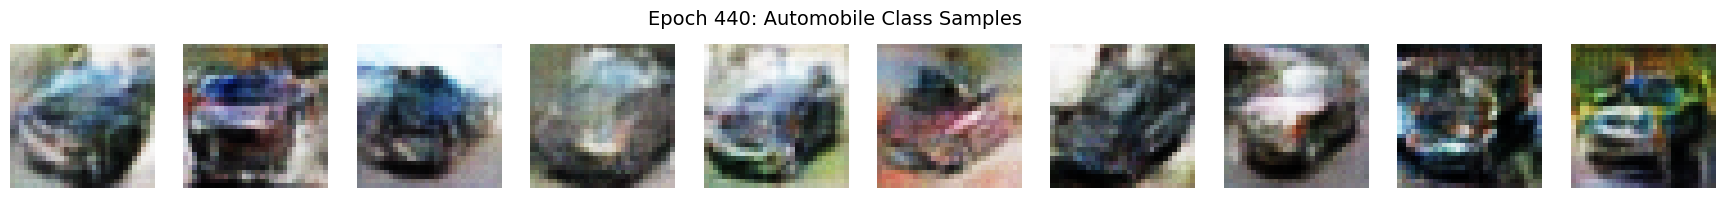

==> Epoch 440: Inception Score = 3.7752, FID = 119.9983
[Epoch 441/550]  Loss Crit: -25510.5234  Loss Gen: 12061.8154
[Epoch 442/550]  Loss Crit: -34159.0508  Loss Gen: 7863.9141
[Epoch 443/550]  Loss Crit: -34291.4531  Loss Gen: 12208.3359
[Epoch 444/550]  Loss Crit: -30166.7266  Loss Gen: 16515.2344
[Epoch 445/550]  Loss Crit: -34637.5898  Loss Gen: 16574.9746
[Epoch 446/550]  Loss Crit: -34745.4727  Loss Gen: 16657.0840
[Epoch 447/550]  Loss Crit: -34864.0430  Loss Gen: 16780.8789
[Epoch 448/550]  Loss Crit: -30689.7051  Loss Gen: 12464.6318
[Epoch 449/550]  Loss Crit: -35224.4219  Loss Gen: 12458.5625
[Epoch 450/550]  Loss Crit: -35354.7539  Loss Gen: 16983.4902
[Epoch 451/550]  Loss Crit: -35556.6094  Loss Gen: 12589.6895
[Epoch 452/550]  Loss Crit: -31194.4980  Loss Gen: 17097.1445
[Epoch 453/550]  Loss Crit: -35806.5820  Loss Gen: 8227.9834
[Epoch 454/550]  Loss Crit: -35961.4805  Loss Gen: 17277.6836
[Epoch 455/550]  Loss Crit: -27090.8008  Loss Gen: 12781.1982
[Epoch 456/550] 

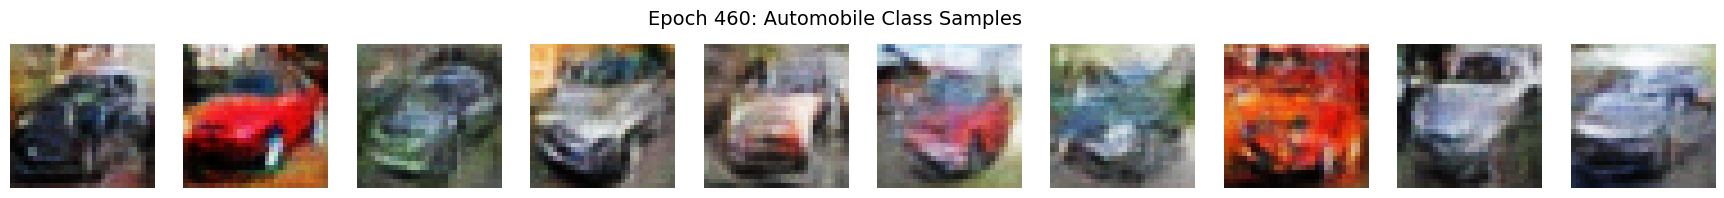

==> Epoch 460: Inception Score = 3.6439, FID = 113.2828
[Epoch 461/550]  Loss Crit: -37030.6094  Loss Gen: 17749.9883
[Epoch 462/550]  Loss Crit: -32535.0762  Loss Gen: 17839.3965
[Epoch 463/550]  Loss Crit: -32678.5527  Loss Gen: 17934.4102
[Epoch 464/550]  Loss Crit: -28102.0332  Loss Gen: 13275.2773
[Epoch 465/550]  Loss Crit: -37642.6133  Loss Gen: 18093.8887
[Epoch 466/550]  Loss Crit: -37811.0430  Loss Gen: 13378.0547
[Epoch 467/550]  Loss Crit: -28494.9082  Loss Gen: 18207.5371
[Epoch 468/550]  Loss Crit: -33369.0352  Loss Gen: 8744.5342
[Epoch 469/550]  Loss Crit: -38273.7969  Loss Gen: 13573.7891
[Epoch 470/550]  Loss Crit: -28847.4609  Loss Gen: 4012.7524
[Epoch 471/550]  Loss Crit: -38580.0234  Loss Gen: 13661.3613
[Epoch 472/550]  Loss Crit: -29104.6641  Loss Gen: 18593.0156
[Epoch 473/550]  Loss Crit: -38947.0820  Loss Gen: 13805.4697
[Epoch 474/550]  Loss Crit: -39055.2695  Loss Gen: 18759.1836
[Epoch 475/550]  Loss Crit: -24526.0664  Loss Gen: 9031.8398
[Epoch 476/550]  

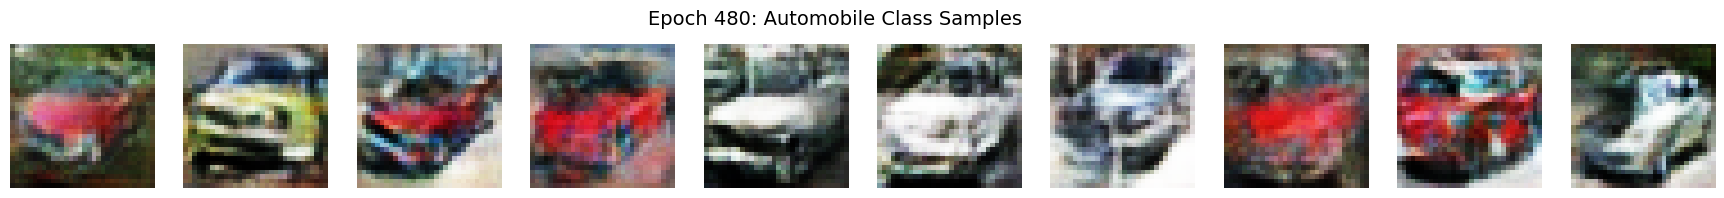

==> Epoch 480: Inception Score = 3.4911, FID = 122.3214
[Epoch 481/550]  Loss Crit: -35066.7461  Loss Gen: 14287.7051
[Epoch 482/550]  Loss Crit: -30273.4023  Loss Gen: 19318.3672
[Epoch 483/550]  Loss Crit: -35434.3750  Loss Gen: 4263.6377
[Epoch 484/550]  Loss Crit: -40652.5547  Loss Gen: 14434.2314
[Epoch 485/550]  Loss Crit: -35743.4688  Loss Gen: 14482.2559
[Epoch 486/550]  Loss Crit: -35838.4062  Loss Gen: 4318.8652
[Epoch 487/550]  Loss Crit: -35977.8711  Loss Gen: 14628.6016
[Epoch 488/550]  Loss Crit: -36116.2500  Loss Gen: 19758.1406
[Epoch 489/550]  Loss Crit: -36262.7539  Loss Gen: 19839.0000
[Epoch 490/550]  Loss Crit: -36437.5156  Loss Gen: 19982.1641
[Epoch 491/550]  Loss Crit: -41747.2422  Loss Gen: 20077.3926
[Epoch 492/550]  Loss Crit: -41986.9531  Loss Gen: 14908.4902
[Epoch 493/550]  Loss Crit: -42096.1797  Loss Gen: 14992.3818
[Epoch 494/550]  Loss Crit: -42303.6289  Loss Gen: 20296.9863
[Epoch 495/550]  Loss Crit: -42423.7500  Loss Gen: 15094.2832
[Epoch 496/550] 

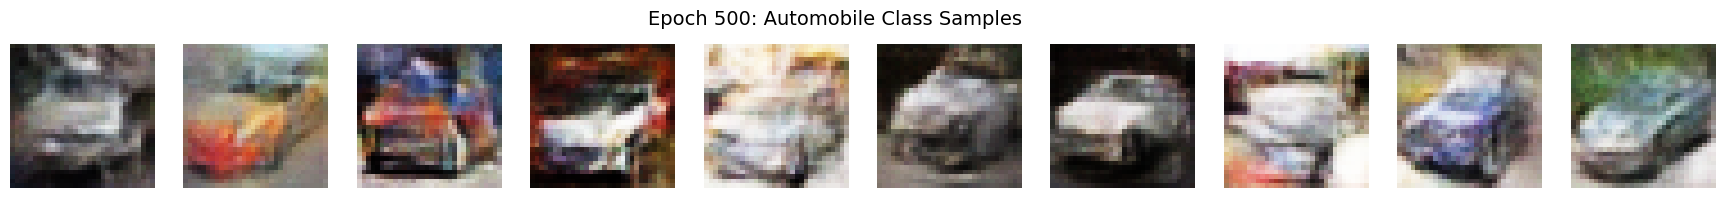

==> Epoch 500: Inception Score = 3.9482, FID = 123.5886
[Epoch 501/550]  Loss Crit: -32555.6348  Loss Gen: 20809.9355
[Epoch 502/550]  Loss Crit: -43564.2773  Loss Gen: 20938.0742
[Epoch 503/550]  Loss Crit: -38290.8672  Loss Gen: 21029.7031
[Epoch 504/550]  Loss Crit: -43967.1680  Loss Gen: 21131.1465
[Epoch 505/550]  Loss Crit: -44105.5312  Loss Gen: 15688.3613
[Epoch 506/550]  Loss Crit: -44284.9883  Loss Gen: 15746.9805
[Epoch 507/550]  Loss Crit: -44495.1367  Loss Gen: 21304.9082
[Epoch 508/550]  Loss Crit: -44624.3281  Loss Gen: 21417.5293
[Epoch 509/550]  Loss Crit: -44804.8867  Loss Gen: 10336.5684
[Epoch 510/550]  Loss Crit: -39340.1523  Loss Gen: 15948.5625
[Epoch 511/550]  Loss Crit: -45087.6836  Loss Gen: 10435.0703
[Epoch 512/550]  Loss Crit: -33946.4219  Loss Gen: 21760.8633
[Epoch 513/550]  Loss Crit: -45449.6641  Loss Gen: 21833.7852
[Epoch 514/550]  Loss Crit: -39939.1875  Loss Gen: 21903.2969
[Epoch 515/550]  Loss Crit: -40047.6953  Loss Gen: 21999.4258
[Epoch 516/550

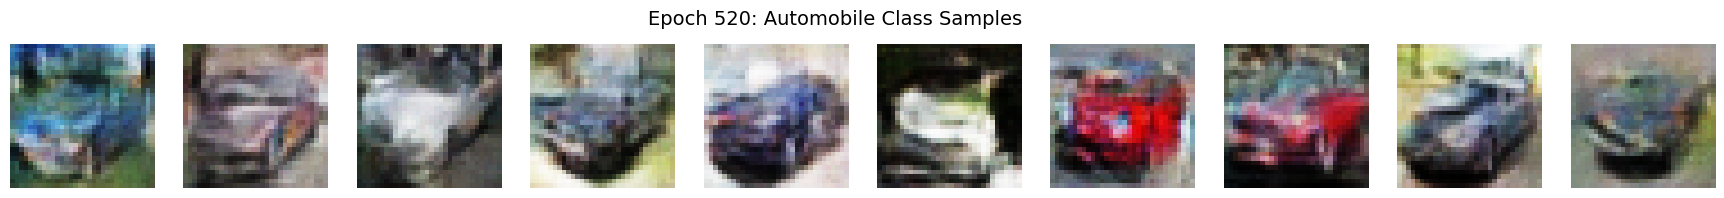

==> Epoch 520: Inception Score = 3.7669, FID = 113.3025
[Epoch 521/550]  Loss Crit: -40962.5391  Loss Gen: 4973.6323
[Epoch 522/550]  Loss Crit: -41141.8828  Loss Gen: 16749.5000
[Epoch 523/550]  Loss Crit: -41324.2422  Loss Gen: 10863.4189
[Epoch 524/550]  Loss Crit: -41400.8789  Loss Gen: 22704.7988
[Epoch 525/550]  Loss Crit: -35598.8750  Loss Gen: 10900.7471
[Epoch 526/550]  Loss Crit: -47670.1758  Loss Gen: 16954.3691
[Epoch 527/550]  Loss Crit: -41862.9727  Loss Gen: 16990.3125
[Epoch 528/550]  Loss Crit: -48039.3789  Loss Gen: 17058.2070
[Epoch 529/550]  Loss Crit: -48183.4492  Loss Gen: 17105.9453
[Epoch 530/550]  Loss Crit: -36282.7188  Loss Gen: 11188.9043
[Epoch 531/550]  Loss Crit: -48537.9023  Loss Gen: 17303.6270
[Epoch 532/550]  Loss Crit: -48800.4453  Loss Gen: 23466.0508
[Epoch 533/550]  Loss Crit: -48924.7227  Loss Gen: 23480.7422
[Epoch 534/550]  Loss Crit: -42978.7734  Loss Gen: 17509.1660
[Epoch 535/550]  Loss Crit: -49290.7344  Loss Gen: 23679.0039
[Epoch 536/550]

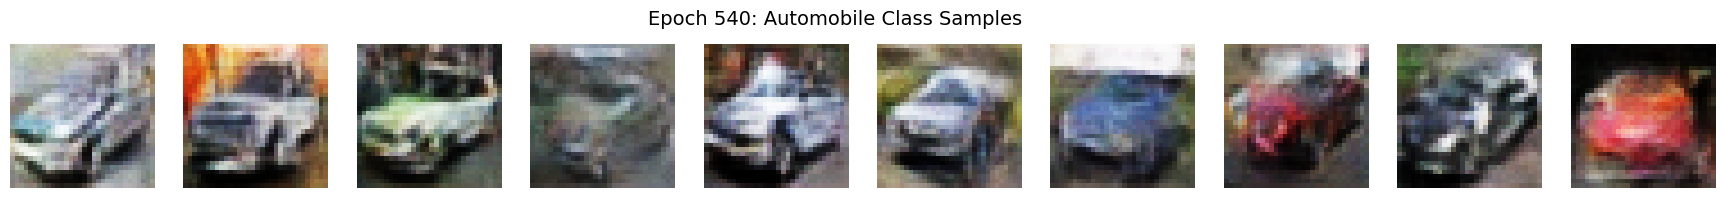

==> Epoch 540: Inception Score = 3.7531, FID = 108.8194
[Epoch 541/550]  Loss Crit: -31465.7891  Loss Gen: 24237.8613
[Epoch 542/550]  Loss Crit: -50488.6562  Loss Gen: 5347.4287
[Epoch 543/550]  Loss Crit: -50698.7773  Loss Gen: 18079.8125
[Epoch 544/550]  Loss Crit: -50831.2930  Loss Gen: 24476.7188
[Epoch 545/550]  Loss Crit: -51058.2930  Loss Gen: 24590.9941
[Epoch 546/550]  Loss Crit: -51230.6055  Loss Gen: 11811.0273
[Epoch 547/550]  Loss Crit: -32166.0312  Loss Gen: 24732.5977
[Epoch 548/550]  Loss Crit: -51645.7656  Loss Gen: 24823.6035
[Epoch 549/550]  Loss Crit: -51777.6797  Loss Gen: 24917.9492
[Epoch 550/550]  Loss Crit: -51947.8008  Loss Gen: 11993.6816
Training complete!


In [20]:
# ---------------------------
# 9. Training Loop
# ---------------------------
for epoch in range(start_epoch, EPOCHS + 1):
    for batch_idx, (real_imgs, labels) in enumerate(trainloader):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        
        # -----------------------
        # Train Critic: K=5 iterations
        # -----------------------
        for _ in range(CRITIC_ITER):
            z = torch.randn(real_imgs.size(0), LATENT_DIM).to(device)
            gen_labels = torch.randint(0, 10, (real_imgs.size(0),), dtype=torch.long, device=device)
            fake_imgs = gen(z, gen_labels)
            
            real_validity = crit(real_imgs, labels)
            fake_validity = crit(fake_imgs.detach(), gen_labels)
            gp = compute_gradient_penalty(crit, real_imgs, fake_imgs.detach(), labels, device)
            loss_crit = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gp
            
            opt_crit.zero_grad()
            loss_crit.backward()
            opt_crit.step()
        
        # -----------------------
        # Train Generator: 1 iteration
        # -----------------------
        z = torch.randn(real_imgs.size(0), LATENT_DIM).to(device)
        gen_labels = torch.randint(0, 10, (real_imgs.size(0),), dtype=torch.long, device=device)
        generated_imgs = gen(z, gen_labels)
        fake_validity = crit(generated_imgs, gen_labels)
        loss_gen = -torch.mean(fake_validity)
        
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(f"[Epoch {epoch}/{EPOCHS}]  Loss Crit: {loss_crit.item():.4f}  Loss Gen: {loss_gen.item():.4f}")

    # -----------------------
    # Save checkpoint, visualize samples, and compute IS/FID every CHECKPOINT_EVERY epochs
    # -----------------------
    if epoch % CHECKPOINT_EVERY == 0:
        checkpoint_data = {
            "epoch": epoch,
            "gen_state_dict": gen.state_dict(),
            "crit_state_dict": crit.state_dict(),
            "opt_gen_state_dict": opt_gen.state_dict(),
            "opt_crit_state_dict": opt_crit.state_dict()
        }
        torch.save(checkpoint_data, checkpoint_path)
        print(f"[epoch={epoch}]Checkpoint saved: {checkpoint_path}")
        
        generate_and_show_samples(epoch, num_samples=10)
        is_val, fid_val = compute_is_fid(gen, trainloader, n_samples=2000)
        print(f"==> Epoch {epoch}: Inception Score = {is_val:.4f}, FID = {fid_val:.4f}")

print("Training complete!")


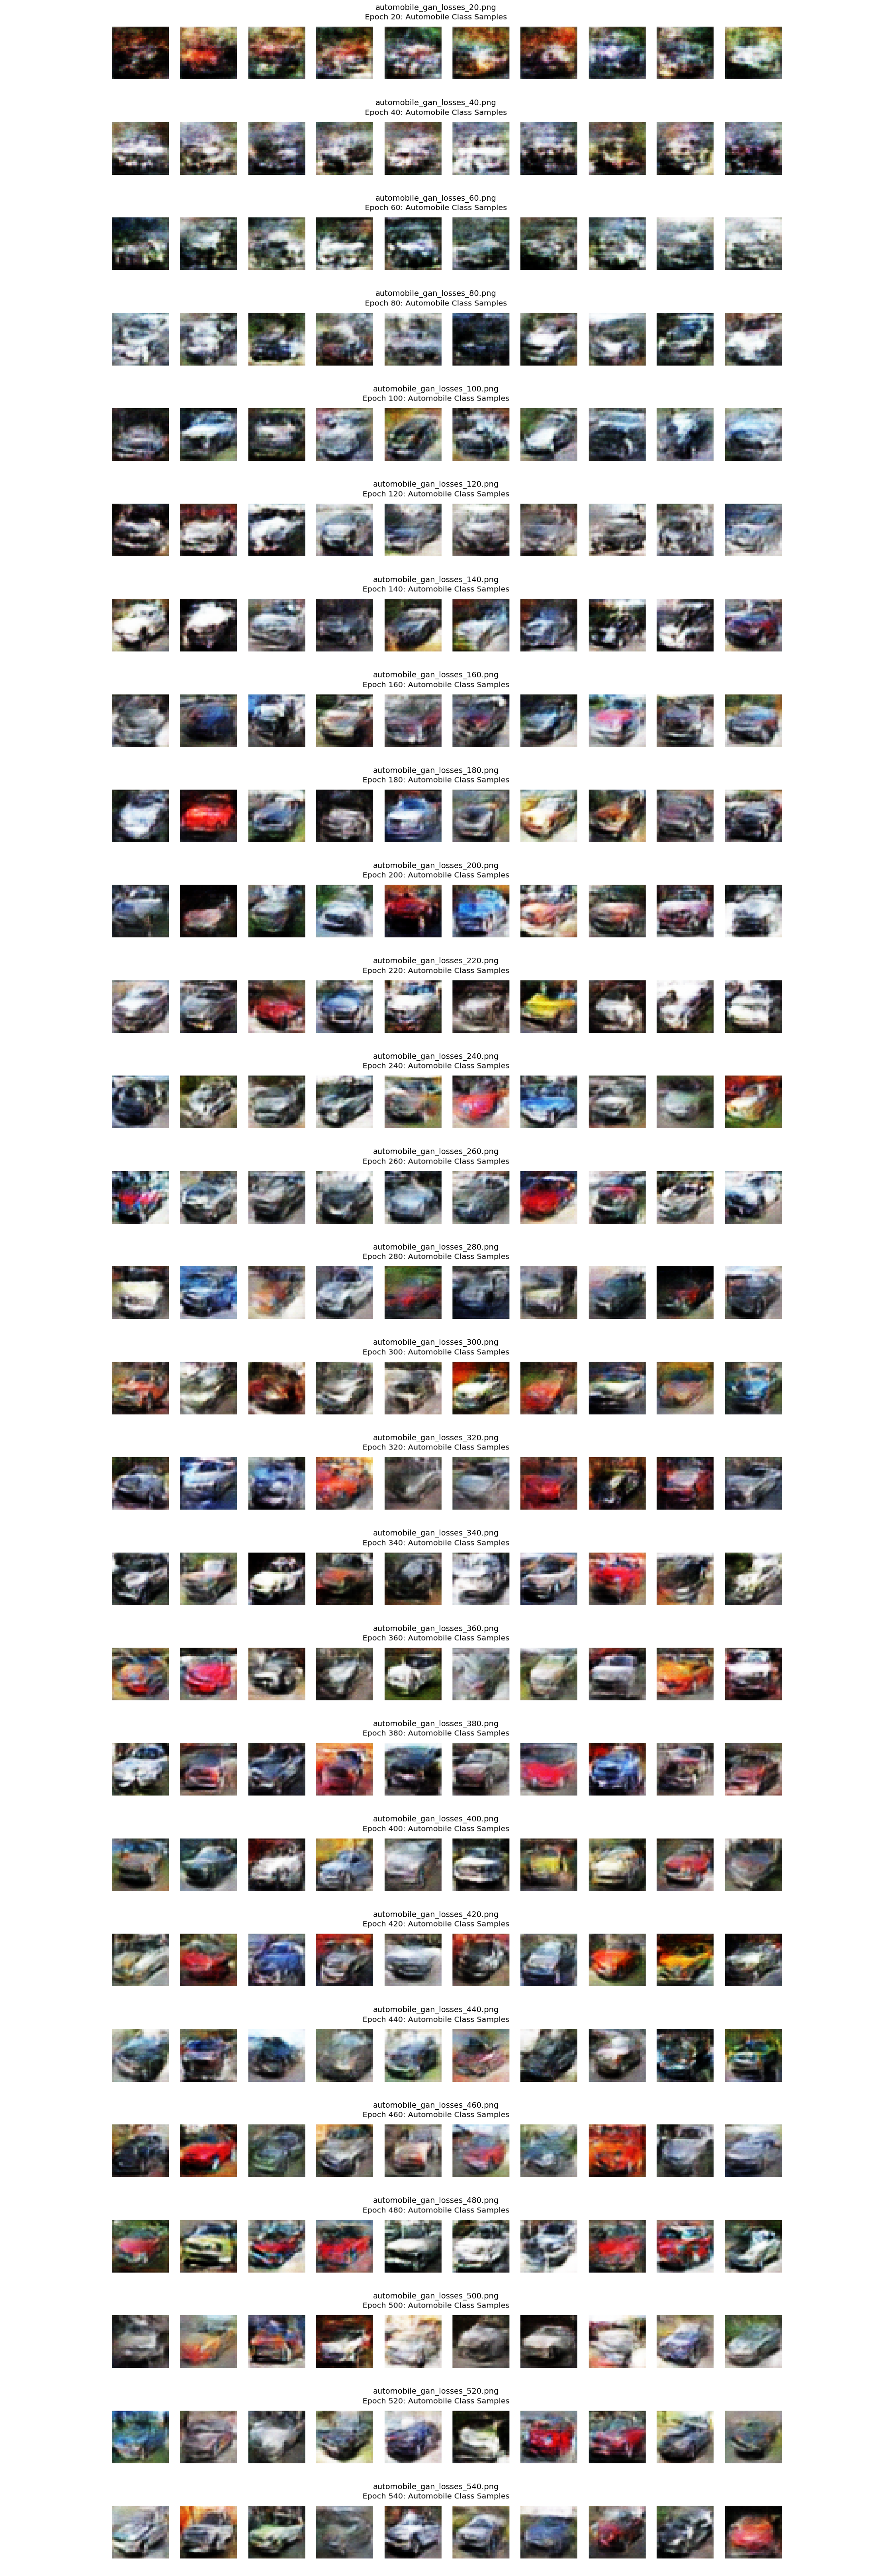

In [21]:
directory = r'task1'
# Define a custom sort key that extracts the epoch number
def extract_epoch(filename):
    base = os.path.basename(filename)
    try:
        # Assuming filename format: automobile_samples_epoch_{epoch_number}.png
        epoch_str = base.split('automobile_gan_losses_')[1].split('.')[0]
        return int(epoch_str)
    except (IndexError, ValueError):
        return float('inf')  # Place any files that don't match the pattern at the end
png_files = glob.glob(os.path.join(directory, '*.png'))
# Sort the list numerically by epoch number
png_files = sorted(png_files, key=extract_epoch)

# Check if any PNG files are found
if not png_files:
    print("No PNG files found in the directory:", directory)
else:
    n = len(png_files)
    
    # Increase the figure size to accommodate full screen-like display
    fig, axs = plt.subplots(n, 1, figsize=(22, 2.4 * n))
    
    # If only one image, wrap axs into a list for consistency
    if n == 1:
        axs = [axs]

    # Attempt to maximize the figure window (works on some backends)
    mng = plt.get_current_fig_manager()
    try:
        # This works for some backends (e.g., TkAgg on Windows)
        mng.window.state('zoomed')
    except AttributeError:
        try:
            # Alternative for other backends (e.g., Qt)
            mng.window.showMaximized()
        except Exception:
            pass  # If it fails, the figure will remain at the set figsize

    # Loop through each file and display the image
    for ax, file in zip(axs, png_files):
        img = mpimg.imread(file)
        ax.imshow(img, aspect='auto')
        ax.axis('off')
        ax.set_title(os.path.basename(file), fontsize=14)
    
    plt.tight_layout()
    plt.show()